In [1]:
import re
import numpy as np
import pandas as pd
import calendar
from datetime import datetime as dt
import matplotlib.pyplot as plt
import matplotlib.cm as cmlib
import matplotlib.ticker as plticker
import datetime as dt2
import seaborn as sns
import statsmodels.api as sm
import statsmodels.stats.weightstats as smS

WMN = 'WMN'
UNKNOWN = 'UNK'
OTHER = 'Other'

AC, FB ='AC','FB'
PE, ALK = 'PE','ALK'
PVC = 'PVC'
CI, CLCI, DI, ELCI, CLDI, GI = 'CI','CLCI', 'DI', 'ELCI', 'CLDI','GI'
IRON='Iron'

MAX_PERCEN_TOSHOW = 2

MAX_PRERanges='PreMax_Range'
LBL_MAX_PRE = 'Max pressure (m)'
LBL_PRE_FLU = 'Pressure fluctuation (m)'

INSERV_PROCESS = 'In Service'
MATERIALS_PREDOMI = [AC,PVC,IRON,PE]

Age_Range = np.arange(0, 115, 5).tolist()
AgeR_labels = [str(i) for i in np.arange(0, 110, 5).tolist()]

Diam_bins = [25 ,75, 115, 135, 165, 190, 225,275,800]
DRange_labels = ['50', '100', '125','150','175','200','250','>300']

PressMax_bins = [20,50,60,70,80,90,120]
PMaxRange_labels = ['(20,50]','(50,60]','(60,70]','(70,80]','(80,90]','(90,120]']

PressFluc_bins = [0,5,10,15,100]
PFlucRange_labels = ['(0,5]','(5,10]','(10,15]','(15,100]']

sns.set_theme(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})
plt.rc('font', size=14)
plt.rc('xtick', labelsize=14) 
plt.rc('ytick', labelsize=14) 
plt.rc('axes', labelsize=14)
plt.rcParams['legend.facecolor'] = 'white'

In [2]:
def getAssetsRecords():

    fname = 'Data/Assets/001-All-Assets_1.csv'
    fname2 = 'Data/Assets/001-All-Assets_2.csv'
    fname3 = 'Data/Assets/001-All-Assets_3.csv'

    AllAssets = pd.read_csv(fname, delimiter = ',', index_col=['Asset Compkey'],
                        dtype = {'Asset Type Code':'str','Asset Service Status':'str','Asset Status':'str','Asset Compkey':'int64' },     
                        usecols=[1,2,3,4,5,6,7])
    AllAssets2 = pd.read_csv(fname2, delimiter = ',', index_col=['Asset Compkey'],
                        dtype = {'Asset Type Code':'str','Asset Service Status':'str','Asset Status':'str','Asset Compkey':'int64' },     
                        usecols=[1,2,3,4,5,6,7])
    AllAssets3 = pd.read_csv(fname3, delimiter = ',', index_col=['Asset Compkey'],
                        dtype = {'Asset Type Code':'str','Asset Service Status':'str','Asset Status':'str','Asset Compkey':'int64' },     
                        usecols=[1,2,3,4,5,6,7])

    AllAssetsCom = AllAssets.append(AllAssets2).append(AllAssets3).copy()

    WaterMain = AllAssetsCom[AllAssetsCom['Asset Type Code'] == WMN].copy()

    print("There are ", WaterMain.shape[0], " water mains in the database (NOT GIS)")

    waterMains = WaterMain[~WaterMain.index.duplicated(keep='first')]

    print("There are ", WaterMain.shape[0], " water mains not duplicated in the database (NOT GIS)")
    
    #rename the index
    waterMains.index.names = [COMPKEY]

    return waterMains


def getFailureRecords(fname,numFailureRecordsOri):
    #Reads the cvs file result from the query to the Watercare DB and store it in a dataframe
    failureRecords = pd.read_csv(fname, delimiter = ',', 
                                 usecols=[0,1,7,9,8,5],
                                 dtype = {WONO:'str', ACTCODE:'str',SERVNO:'str',SR_PROB:'str',
                                          ADDDTTM:'str', COMPKEY:'int64'},
                                 index_col=0,
                                 parse_dates=[ADDDTTM],
                                )[[SERVNO,ACTCODE,SR_PROB,ADDDTTM,COMPKEY]]
    numFailureRecordsOri= failureRecords.shape[0]
    print('Number of records from the DB query:' , numFailureRecordsOri)

    failureRecords= failureRecords[~failureRecords.index.duplicated()].copy()

    print('Number of failure records:', failureRecords.shape[0], ' Deleted records duplicated WONO: ', numFailureRecordsOri - failureRecords.shape[0])
    numFailureRecordsOri = failureRecords.shape[0]

    #For this study if it is the same type of Repair activity on the same asset associated 
    #to the same service number and in the same date 
    #The duplicated values are due diferencees in the contractor reference numbers used to add parts of the costs.
    #therefore the duplicates are not necesary unless the cost is needed
    failureRecords.drop_duplicates(inplace=True)

    #check for duplicates using only the date (not datetime) in the extraMethods.py file!!

    print('Number of failure records:', failureRecords.shape[0], ' Deleted records: ', numFailureRecordsOri - failureRecords.shape[0])
    numFailureRecordsOri = failureRecords.shape[0]
    return failureRecords, numFailureRecordsOri

def getFilterCodesAndSR() :

	fileACTCODE = 'Data/01-ACTCODERepair.csv'
	fileSR_Prob = 'Data/02-SR_PROB_TO_FILTER.csv'

	#read the filter files
	ACTCODERepair = pd.read_csv(fileACTCODE)
	SR_ToFilter = pd.read_csv(fileSR_Prob)

	return ACTCODERepair, SR_ToFilter

def filters3PandNotRepairs(failureRecords, SR_ToFilter, ACTCODERepair, numFailureRecordsOri):
	#filters the service codes related to third parties---------------------------------------------------------------
    failureRecords= failureRecords[~failureRecords[SR_PROB].isin(SR_ToFilter['SR_PROB_TO_FILTER'])].copy()
    
    print('Number of failure records:', failureRecords.shape[0], ' 3P Deleted records: ', numFailureRecordsOri - failureRecords.shape[0])
    numFailureRecordsOri = failureRecords.shape[0]


	#filters the activities with actcodes not related to repairs------------------------------------------------------
    failureRecords= failureRecords[failureRecords[ACTCODE].isin(ACTCODERepair[ACTCODE])].copy()
    
    print('Number of failure records:', failureRecords.shape[0], ' Not repair Deleted records: ', numFailureRecordsOri - failureRecords.shape[0])
    numFailureRecordsOri = failureRecords.shape[0]
    
    return failureRecords, numFailureRecordsOri

def getAddressFromFailureRecords(fname):

	addressRecords = pd.read_csv(fname, delimiter = ',', 
								usecols=[0,12,13,14,15,16,17],
								dtype = {WONO:'str', 'Street_Type':'str','Street_Name':'str',SUBURB:'str',
								'FLAT':'str','HOUSENO':'str','POSTCODE':'str'})

	addressRecords.drop_duplicates(inplace=True)
	addressRecords.set_index(WONO, inplace=True, drop=True)

	return addressRecords

def filterFailuresbyInconsistentAddress(failures, addressRecords, assetAddresses):

	#adds the compkeys to the addressess of the failure table 
    failAddr= failures.join(addressRecords)[[COMPKEY,'Street_Type','Street_Name',SUBURB]]
    failAddr=failAddr.astype({COMPKEY: 'int64'})

	#creates the table to compare addresses 
    addrComp= failAddr.join(assetAddresses, on=COMPKEY)

	#compare the suburbs and drop the values that dont match
    indexToFilter= addrComp[addrComp[SUBURB].str.upper()!=addrComp[SUBURB].str.upper()].index
    failures.drop(indexToFilter , inplace=True)
    
    return failures

def getFailuresWithPipes(mainFailures, WMNFromAssetRecordsIndex):

	fWPipes = 'Data/00-Water_Pipe.csv'

	wPipesGIS = pd.read_csv(fWPipes, delimiter = ',', 
		                                dtype = {COMPKEY:'int64',STATUS:'str',MATERIAL:'str',
		                                         NOM_DIA_MM:'str',INSTALLED:'str',
                                                 'Shape_Leng' : 'float64'},
		                                usecols=[2,8,9,11,12,18],
		                                parse_dates=[INSTALLED],
		                                index_col=[COMPKEY]
		                                )

	print("Records of pipes (GIS) ",  wPipesGIS.shape[0], " length ", "%.2f" % wPipesGIS['Shape_Leng'].sum())
	originalGIS = wPipesGIS.shape[0]
    
    #merge duplicates compkeys
	wPipesGIS = wPipesGIS.groupby(wPipesGIS.index).agg({'Shape_Leng':sum, STATUS: 'first', NOM_DIA_MM: 'first', MATERIAL : 'first', INSTALLED:'first'})
	print("Records of pipes (GIS) ",  wPipesGIS.shape[0], " total length ", "%.2f" % wPipesGIS['Shape_Leng'].sum(),". Removed COMPKEY duplicates: ", originalGIS - wPipesGIS.shape[0])
	originalGIS = wPipesGIS.shape[0]
	
	#Delete no main pipes by the all assets dataset
	wPipesGIS = wPipesGIS[wPipesGIS.index.isin(WMNFromAssetRecordsIndex)].copy()
	print("Records of main pipes (GIS) ",  wPipesGIS.shape[0], ". Removed pipes with all assets WMN: ", originalGIS - wPipesGIS.shape[0])
	
    
	#look for the pipes of the failures and create a table with number of failure per pipe
	mainF_GISPipes= mainFailures.join(wPipesGIS, on= COMPKEY).copy()
	failuresWithPipesMissingInGIS = mainF_GISPipes[pd.isna(mainF_GISPipes['Shape_Leng'])].copy()
	failuresWithPipesInGIS = mainF_GISPipes[~pd.isna(mainF_GISPipes['Shape_Leng'])].copy()
	print('Failures with pipes in the GIS ', failuresWithPipesInGIS.shape[0], '. Failures with pipes missing in GIS ', failuresWithPipesMissingInGIS.shape[0])


	return failuresWithPipesInGIS, wPipesGIS


def manage_GISPipes(mainFailures,WMNFromAssetRecordsIndex):

    failuresWithPipesInGIS, wPipesGIS = getFailuresWithPipes(mainFailures,WMNFromAssetRecordsIndex)

    countNumFPerPipe = failuresWithPipesInGIS.groupby([COMPKEY]).agg({SERVNO: 'count', ACTCODE : 'first'})
    countNumFPerPipe.rename(columns={SERVNO:'Num of failures'}, inplace= True)


    #asign the number of failures per pipe including 0 to all the main pipe table and change formats
    wPipesGIS[NOM_DIA_MM] = pd.to_numeric(wPipesGIS[NOM_DIA_MM],errors='coerce')
    wPipesGISNfailures = wPipesGIS.join(countNumFPerPipe[['Num of failures']])
    wPipesGISNfailures["Num of failures"].fillna(0, inplace=True)
    wPipesGISNfailures["Age Today"] = (pd.to_datetime('today').tz_localize('UTC')-pd.to_datetime(wPipesGISNfailures["INSTALLED"])).astype('<m8[Y]')
    
    #calculates the age of failure and removes incorrect values
    failuresWithPipesInGIS["Age at failure"] = (pd.to_datetime(failuresWithPipesInGIS["ADDDTTM"].dt.tz_localize(None)) 
    - pd.to_datetime(failuresWithPipesInGIS["INSTALLED"]).dt.tz_localize(None)).astype('<m8[Y]')
    
    failuresWithPipesInGIS= failuresWithPipesInGIS[failuresWithPipesInGIS["Age at failure"]>=0].copy()
    
    for df in [failuresWithPipesInGIS,wPipesGISNfailures]:
        
        df['Shape_Leng'] = df['Shape_Leng']/1000 #pass to km
        df[MATERIAL] = df[MATERIAL].replace(UNKNOWN, np.nan)
        df[NOM_DIA_MM].fillna(0, inplace=True)

        #Combine AC
        df[MATERIAL] = df[MATERIAL].replace(FB, AC)

        #Combine PE
        df[MATERIAL] = df[MATERIAL].replace(ALK, PE)

        #combine CI
        df[MATERIAL] = df[MATERIAL].replace(CLCI, IRON)
        df[MATERIAL] = df[MATERIAL].replace(DI, IRON)
        df[MATERIAL] = df[MATERIAL].replace(ELCI, IRON)
        df[MATERIAL] = df[MATERIAL].replace(CLDI, IRON)
        df[MATERIAL] = df[MATERIAL].replace(GI, IRON)
        df[MATERIAL] = df[MATERIAL].replace(CI, IRON) 

    return wPipesGISNfailures, failuresWithPipesInGIS


# -------------------- CONST --------------------

In [3]:
def getMaterialConst():
    
    fmaterialsConst='Data/Const-Materials.csv'

    materialsConst = pd.read_csv(fmaterialsConst, delimiter = ',', index_col=[MATERIAL])
    
    return materialsConst

def getDiameterConst():
    
    fdiameterConst='Data/Const-Diameter.csv'

    diameterConst = pd.read_csv(fdiameterConst, delimiter = ',', index_col=[DIAMETER])
    
    return diameterConst

def getAgeConst():
    
    fageConst='Data/Const-Ages.csv'

    ageConst = pd.read_csv(fageConst, delimiter = ',', index_col=['Age'])
    
    return ageConst

In [4]:
def getBase():
    
    fname = 'Data/03-WorkOrders.csv'
    numFailureRecordsOri = 0

    failureRecords , numFailureRecordsOri = getFailureRecords(fname,numFailureRecordsOri)
    ACTCODERepair, SR_ToFilter = getFilterCodesAndSR()

    failureRecords , numFailureRecordsOri = filters3PandNotRepairs(failureRecords, SR_ToFilter, ACTCODERepair,numFailureRecordsOri)

    #divide between MAIN and SERViCE LINES------------------------------------------------
    mainFailures = failureRecords[(failureRecords[ACTCODE]=='WMNRM') | (failureRecords[ACTCODE]=='WMNRPL')].copy()

    numFailRecordsOriM = mainFailures.shape[0]

    print('Number of failures in Mains :', numFailRecordsOriM)

    addressFromFailureRecords = getAddressFromFailureRecords(fname)
    WMNFromAssetRecords = getAssetsRecords()

    mainFailures = filterFailuresbyInconsistentAddress(mainFailures, addressFromFailureRecords, WMNFromAssetRecords)
    print('Number of failures in Mains :', mainFailures.shape[0], ' Different address Deleted records: ', numFailRecordsOriM - mainFailures.shape[0])

    numFailRecordsOriM=mainFailures.shape[0]

    #returns the shape_length in km
    wPipesGISNfailures, failuresWithPipesInGIS = manage_GISPipes(mainFailures,WMNFromAssetRecords.index.tolist())

    
    #remove non predominan materials  and sort them 
    predoMaterials = wPipesGISNfailures[wPipesGISNfailures[MATERIAL].isin(MATERIALS_PREDOMI)].copy()
    predoMaterials.MATERIAL = pd.Categorical(predoMaterials.MATERIAL,categories= MATERIALS_PREDOMI)
    predoMaterials=predoMaterials.sort_values(MATERIAL).copy()

    failuresPMaterials= failuresWithPipesInGIS[failuresWithPipesInGIS[MATERIAL].isin(MATERIALS_PREDOMI)].copy()
    failuresPMaterials.MATERIAL = pd.Categorical(failuresPMaterials.MATERIAL,categories= MATERIALS_PREDOMI)
    failuresPMaterials=failuresPMaterials.sort_values(MATERIAL).copy()
    
    return predoMaterials, failuresPMaterials


predoMaterials, failuresPMaterials = getBase()
consCoM = getMaterialConst()['Color']
pal=[consCoM[m] for m in MATERIALS_PREDOMI]

Number of records from the DB query: 590379
Number of failure records: 590271  Deleted records duplicated WONO:  108
Number of failure records: 570948  Deleted records:  19323
Number of failure records: 558467  3P Deleted records:  12481
Number of failure records: 92691  Not repair Deleted records:  465776
Number of failures in Mains : 14735


/home/ubuntu/.local/lib/python3.6/site-packages/numpy/lib/arraysetops.py:580: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


There are  232986  water mains in the database (NOT GIS)
There are  232986  water mains not duplicated in the database (NOT GIS)
Number of failures in Mains : 13107  Different address Deleted records:  1628
Records of pipes (GIS)  619384  length  11486294.71
Records of pipes (GIS)  612465  total length  11486294.71 . Removed COMPKEY duplicates:  6919
Records of main pipes (GIS)  212535 . Removed pipes with all assets WMN:  399930
Failures with pipes in the GIS  13057 . Failures with pipes missing in GIS  50


# -------------------------- UTILS ---------------------------------------------

In [5]:
def removeTopRightFrame(ax):
    
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    
    return ax

def setViolinAlpha(ax):
    
    for violin in ax.collections[::2]:
        violin.set_alpha(0.7)
        
# Only for the Facegrid distribution graph
# Define and use a simple function to label the plot in axes coordinates
def label(x, color, label):

    ax = plt.gca()
    #include color=color if the labels should be colored
    ax.text(-0.05, 0.3, label, ha="left", va="center", transform=ax.transAxes)
    
def createBrokenAxisEffectNoRight(ax1, ax2):
    
    ax1.spines['bottom'].set_visible(False)
    
    d = .015  # how big to make the diagonal lines in axes coordinates
    # arguments to pass to plot, just so we don't keep repeating them
    kwargs = dict(transform=ax1.transAxes, color='k', clip_on=False)
    ax1.plot((-d, +d), (-d, +d), **kwargs)        # top-left diagonal
    #ax1.plot((1 - d, 1 + d), (-d, +d), **kwargs)  # top-right diagonal

    kwargs.update(transform=ax2.transAxes)  # switch to the bottom axes
    ax2.plot((-d, +d), (1 - d, 1 + d), **kwargs)  # bottom-left diagonal
    #ax2.plot((1 - d, 1 + d), (1 - d, 1 + d), **kwargs)  # bottom-right diagonal

    return ax1, ax2

# --------------------INTRINSIC CHARACTERISTICS ANALYSIS--------------------

In [6]:
inService = predoMaterials[predoMaterials[STATUS] == INSERV_PROCESS].copy()

failuresPMaterials["Age at failure"] = (pd.to_datetime(failuresPMaterials["ADDDTTM"].dt.tz_localize(None)) 
    - pd.to_datetime(failuresPMaterials["INSTALLED"]).dt.tz_localize(None)).astype('<m8[Y]')

In [7]:
def putInRanges(df,colRanges,col,bins,labels,getValidationVals,startCol,finishCol):
    
    df[colRanges]= pd.cut(df[col], bins=bins, labels=labels)
    #remove invalid values (nulls)----------------------------------
    dfOK= df[~pd.isna(df[colRanges])].copy()
    
    if getValidationVals is not None:
        const= getValidationVals()
        for i in const.index:
            dfOK = dfOK.drop(dfOK[(dfOK.MATERIAL == i) & (dfOK[col]<const.loc[i, startCol])].index)
            dfOK = dfOK.drop(dfOK[(dfOK.MATERIAL == i) & (dfOK[col]>const.loc[i,finishCol])].index)
    
    print("(Main in service) Pipe length with valid ",col+" ","%.2f" % dfOK['Shape_Leng'].sum()," from original ", "%.2f" % df['Shape_Leng'].sum())
    
    return dfOK


# End from base analysis -------------------------------------------------------------

# Start from Pressure analysis --------------------------------------------------------

In [8]:
def getFailuresWithPressures(df):

	# Join by vicinity of the shape file "Water_Pipe" from Nish with the file of preassures from Mike
    fGISPipesPressure = 'Data/09-JoinWater_PipeVsPressure.csv'

    GISpipesVsPressures = pd.read_csv(fGISPipesPressure, delimiter = ',', 
	                            dtype = {COMPKEY:'int64', 'MOD_MAXPRE':'float64','MOD_MINPRE':'float64','Press_fluc':'float64',
                                        'Distance': 'float64'},
								usecols=[3,25,26,38,39,35],
	                            index_col=[COMPKEY])

    GISpipesVsPressures = GISpipesVsPressures.groupby(GISpipesVsPressures.index).agg({'MOD_MAXPRE': 'mean', 'MOD_MINPRE': 'mean',
                                                                                      'Press_fluc': 'mean', 'Distance': 'mean',
                                                                                     'MODEL_NAME': 'first'})

    wPipesGISNfailuresPressure = df.join(GISpipesVsPressures)
    print("Total Length of pipes with pressure (GIS)", "%.2f" % wPipesGISNfailuresPressure['Shape_Leng'].sum(), " in ",  wPipesGISNfailuresPressure.shape[0], "records")
    assert df.shape[0] == wPipesGISNfailuresPressure.shape[0]
    
    #remove pipes without near nodes
    dfNPressures= wPipesGISNfailuresPressure[wPipesGISNfailuresPressure['Distance']<1].copy()
    print("Total Length of pipes with VALID distance to pressure (GIS)", "%.2f" % dfNPressures['Shape_Leng'].sum(), " in ",  dfNPressures.shape[0], "records")

    
    #modify the names so they match with waterModelExtent 
    dfNPressures['MODEL_NAME']= dfNPressures['MODEL_NAME'].replace('_',' ', regex=True).str.title()
    dfNPressures['MODEL_NAME']=dfNPressures['MODEL_NAME'].replace({'Greenhithe Kyle':'Greenhithe & Kyle',
                                                    'Snells Algies' :'Snells & Algies','Gptk':'GPTK','Acg':'ACG',
                                                    'Okhd':'OKHD', 'Takg':'TAKG','Cbd':'CBD'})
    
    return dfNPressures

# End from pressure analysis ---------------------------------------------------------

# Start Coordinates analysis ----------------------------------------------------

In [9]:
def getCoordinates(df):

    # Join by vicinity of the shape file "Water_Pipe" from Nish with the file of preassures from Mike
    fGISPipesCoord = 'Data/Coordinates/CoordinatesMiddlePointAll.txt'

    GISPipesCoord = pd.read_csv(fGISPipesCoord, delimiter = ',',
                               dtype = {COMPKEY:'int64', 'LAT':'float64','LONG':'float64'},
                                usecols=[3,24,25],
                                index_col=[COMPKEY])

    GISPipesCoord = GISPipesCoord.groupby(GISPipesCoord.index).agg({'LAT': 'first', 'LONG': 'first'})

    dfNCoordinates = df.join(GISPipesCoord)
    print("Total Length of pipes with coordinates (GIS)", "%.2f" % dfNCoordinates['Shape_Leng'].sum(), " in ",  dfNCoordinates.shape[0], "records")
    assert df.shape[0] == dfNCoordinates.shape[0]
    
    print("MaxLat:",dfNCoordinates['LAT'].max(),"MinLat:",dfNCoordinates['LAT'].min())
    print("MaxLong:",dfNCoordinates['LONG'].max(),"MinLong:",dfNCoordinates['LONG'].min())
    
    return dfNCoordinates


def getCoordinatesGrouped(df,material):
    
    dfm=df[df[MATERIAL]== material].copy()
    
    dfm['LAT']= dfm['LAT'].round(0)
    dfm['LONG']= dfm['LONG'].round(0)
    
    dfGrouped= dfm.groupby(["LAT","LONG"]).agg({'Shape_Leng':sum, 'Num of failures': sum}).copy()
    
    dfGrouped['Failures/Km/year']= (dfGrouped['Num of failures']/dfGrouped['Shape_Leng']/6).replace(0, np.NAN)
    dfGrouped= dfGrouped.dropna()
    
    #remove outliners
    iqr = dfGrouped.quantile(0.75, numeric_only=False) - dfGrouped.quantile(0.25, numeric_only=False)
    limN = np.abs((dfGrouped - dfGrouped.median()) / iqr) < 2.22


    # replace outliers with nan
    dfGrouped['Failures/Km/year'] = dfGrouped.where(limN, np.nan)
    dfGrouped= dfGrouped.dropna()
    
    dfGrouped= dfGrouped.reset_index()
    
    return dfGrouped


def getCoordinatesHeatMap(df):
    
    dfCoor= getCoordinates(df)
    
    for m in MATERIALS_PREDOMI:
        
        mDf = getCoordinatesGrouped(dfCoor.copy(),m)
    
        fig, ax = plt.subplots(figsize=(11,20))
        
        print(mDf['Failures/Km/year'].min(), " ", mDf['Failures/Km/year'].max())

        sc = ax.scatter(mDf.LAT, mDf.LONG, c=mDf['Failures/Km/year'],cmap='cool',vmin=0,vmax=0.4)
        
        fig.colorbar(sc, ax=ax)
        
        ax.set_xlim([1727960,1783925])
        ax.set_ylim([5874605,5983394])
        

Total Length of pipes with coordinates (GIS) 9172.63  in  198694 records
MaxLat: 1778247.88967 MinLat: 1727590.4969
MaxLong: 5986639.7981 MinLong: 5874217.251150001
2.2671568675242998e-05   0.34578655260340907
0.00020343672190799802   0.392010405066232
7.558108201683501e-05   0.23239195544697397
5.9976662030149e-05   0.3755645910256369


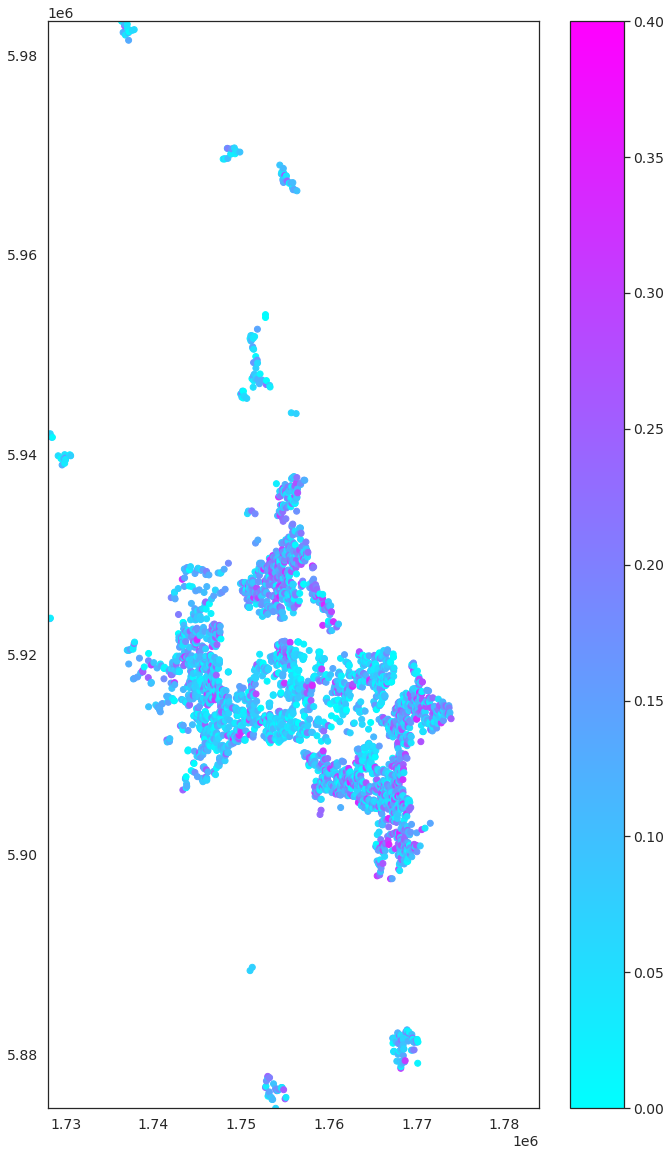

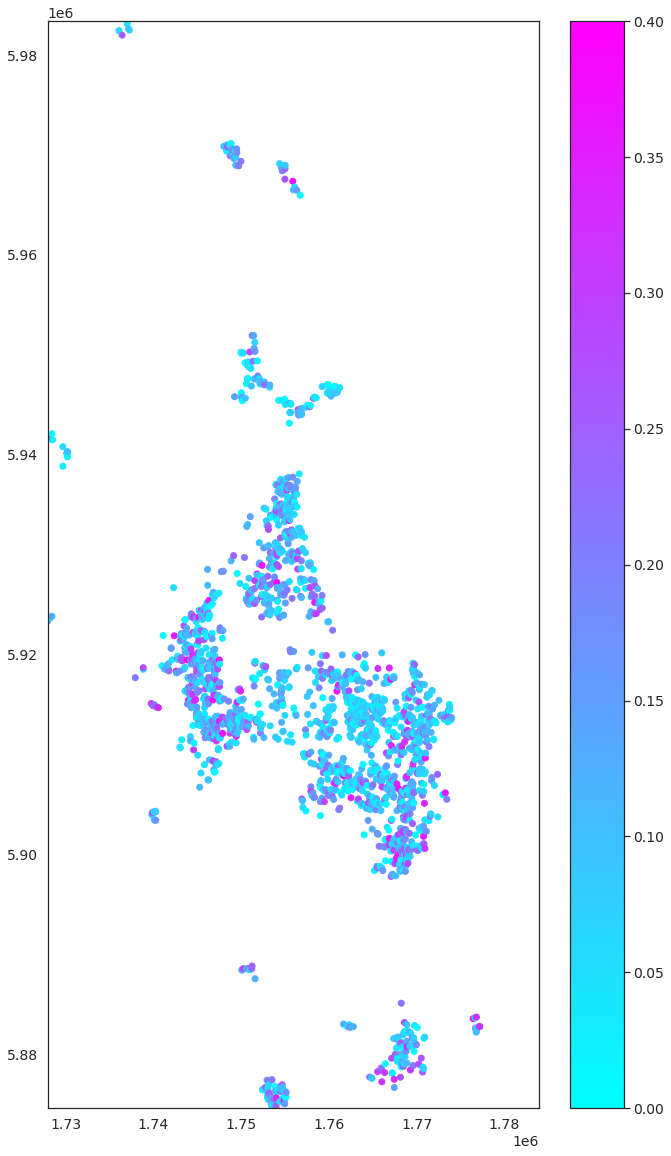

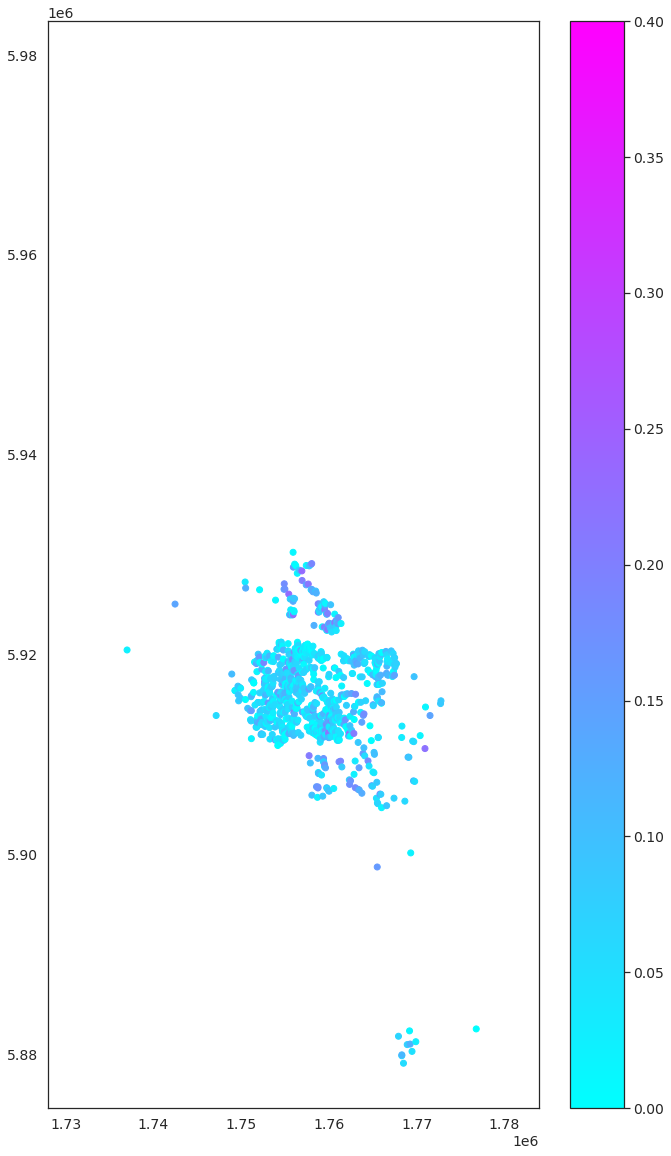

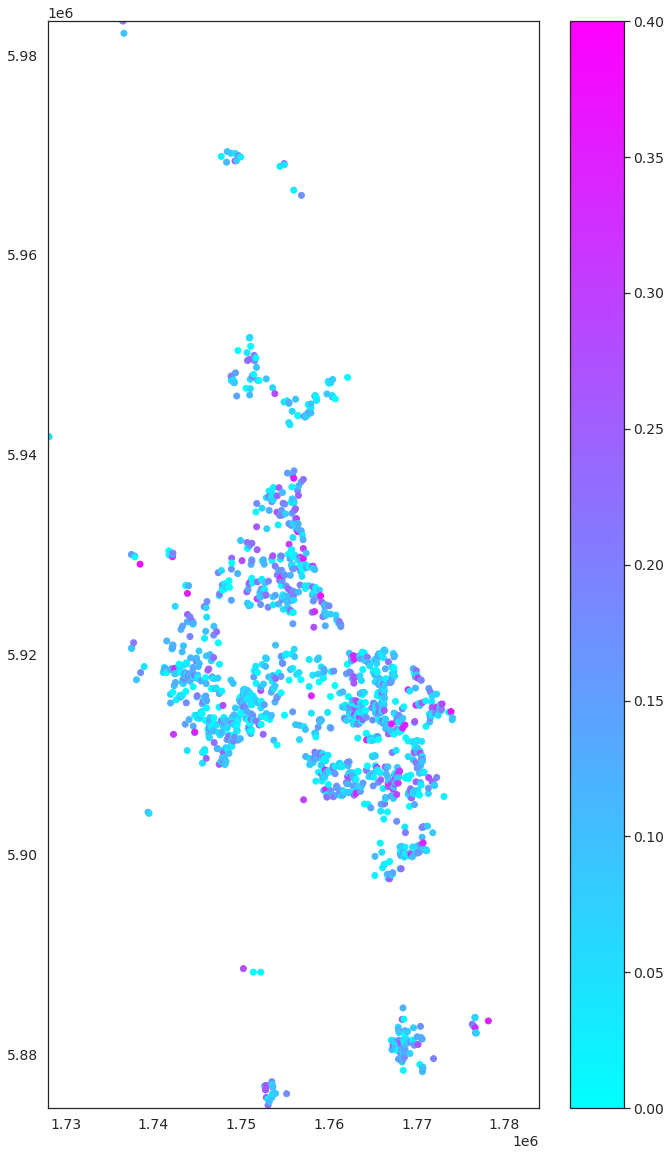

In [10]:
getCoordinatesHeatMap(predoMaterials.copy())  

In [17]:
def getCoordinatesMaterialsRange(df):
    
    dfCoor= getCoordinates(df)
    
    #long and lat difference by 20 m
    Lat_Range = np.arange(1720000,1780000, 1200).tolist()
    Lat_labels = [i for i in np.arange(1720000,1778800, 1200).tolist()]
    
    Long_Range = np.arange(5870000,5990000, 1200).tolist()
    Long_labels = [i for i in np.arange(5870000,5988800, 1200).tolist()]
    
    #PUts the coordinates in ranges
    dfCoor["LATR"]= pd.cut(dfCoor["LAT"], bins=Lat_Range, labels=Lat_labels)
    dfCoor["LONGR"]= pd.cut(dfCoor["LONG"], bins=Long_Range, labels=Long_labels)
    
    #remove invalid values (nulls)----------------------------------
    dfCoor.dropna(subset=['LATR', 'LONGR'])
    
    dfGrouped= dfCoor.groupby(["LATR","LONGR","MATERIAL"], observed=True).agg({'Shape_Leng':sum}).copy()
    dfGrouped= dfGrouped.sort_values(['Shape_Leng'],ascending=False).reset_index().groupby(["LATR","LONGR"], observed=True).agg({MATERIAL:'first'})
    
    dfGrouped= dfGrouped.reset_index()

    dfGrouped['Color'] = dfGrouped[MATERIAL].map(consCoM.to_dict())
    
    return dfGrouped

def getCoordinatesRangeGrouped(df,material):
    
    dfm=df[df[MATERIAL]== material].copy()
    
    #long and lat difference by 20 m
    Lat_Range = np.arange(1720000,1780000, 1200).tolist()
    Lat_labels = [i for i in np.arange(1720000,1778800, 1200).tolist()]
    
    Long_Range = np.arange(5870000,5990000, 1200).tolist()
    Long_labels = [i for i in np.arange(5870000,5988800, 1200).tolist()]
    
    dfm["LATR"]= pd.cut(dfm["LAT"], bins=Lat_Range, labels=Lat_labels)
    dfm["LONGR"]= pd.cut(dfm["LONG"], bins=Long_Range, labels=Long_labels)
    
    #remove invalid values (nulls)----------------------------------
    dfm.dropna(subset=['LATR', 'LONGR'])
    
    #Observed true= doesnt create ranges that are empty 
    dfGrouped= dfm.groupby(["LATR","LONGR"], observed=True).agg({'Shape_Leng':sum, 'Num of failures': sum}).copy()
    
    dfGrouped['Failures/Km/year']= (dfGrouped['Num of failures']/dfGrouped['Shape_Leng']/6).replace(0, np.NAN)
    dfGrouped= dfGrouped.dropna()
    
    #remove outliners
    iqr = dfGrouped.quantile(0.75, numeric_only=False) - dfGrouped.quantile(0.25, numeric_only=False)
    limN = np.abs((dfGrouped - dfGrouped.median()) / iqr) < 2.22

    # replace outliers with nan
    dfGrouped['Failures/Km/year'] = dfGrouped.where(limN, np.nan)
    dfGrouped= dfGrouped.dropna()
    
    dfGrouped= dfGrouped.reset_index()
    
    return dfGrouped

def getCoordinatesMatDistribution(df):
    
    mDf = getCoordinatesMaterialsRange(df.copy())
    
    fig, ax = plt.subplots(figsize=(10,20))

    sc = ax.scatter(mDf.LATR, mDf.LONGR, c=mDf['Color'])
    
    ax.set_xlim([1720000,1780000])
    ax.set_ylim([5870000,5990000])
    ax.set_xlabel("Longitude")
    ax.set_ylabel("Latitude")
    ax.xaxis.set_minor_locator(plticker.MultipleLocator(5000))
    ax.yaxis.set_minor_locator(plticker.MultipleLocator(5000))
    ax.grid(axis='x', which='both')
    ax.grid(axis='y', which='both')   
    ax.legend(ncol=1, facecolor='white',fontsize=14,loc='upper center', bbox_to_anchor=(1.2, 0.5))
    
    
    fig.savefig('Maps_Graph/CoordinatesAnalysis/'+'MaterialVsCoord'+'.png', dpi=200, bbox_inches='tight')
    
    return mDf
    
    

def getCoordinatesHeatMapRange(df):
    
    dfCoor= getCoordinates(df)
    
    for m in MATERIALS_PREDOMI:
        
        mDf = getCoordinatesRangeGrouped(dfCoor.copy(),m)
    
        fig, ax = plt.subplots(figsize=(10,20))
        
        print(mDf['Failures/Km/year'].min(), " ", mDf['Failures/Km/year'].max())

        sc = ax.scatter(mDf.LATR, mDf.LONGR, c=mDf['Failures/Km/year'],cmap='cool',vmin=0,vmax=21)
        
        fig.colorbar(sc, ax=ax)
        
        ax.set_xlim([1720000,1780000])
        ax.set_ylim([5870000,5990000])
        ax.set_xlabel("Longitude")
        ax.set_ylabel("Latitude")
        ax.set_title(m)
        ax.xaxis.set_minor_locator(plticker.MultipleLocator(5000))
        ax.yaxis.set_minor_locator(plticker.MultipleLocator(5000))
        ax.grid(axis='x', which='both')
        ax.grid(axis='y', which='both')
      
        fig.savefig('Maps_Graph/CoordinatesAnalysis/'+'BurstRateVsCoord' +m+'.png', dpi=200, bbox_inches='tight')
    



Total Length of pipes with coordinates (GIS) 9172.63  in  198694 records
MaxLat: 1778247.88967 MinLat: 1727590.4969
MaxLong: 5986639.7981 MinLong: 5874217.251150001


No handles with labels found to put in legend.


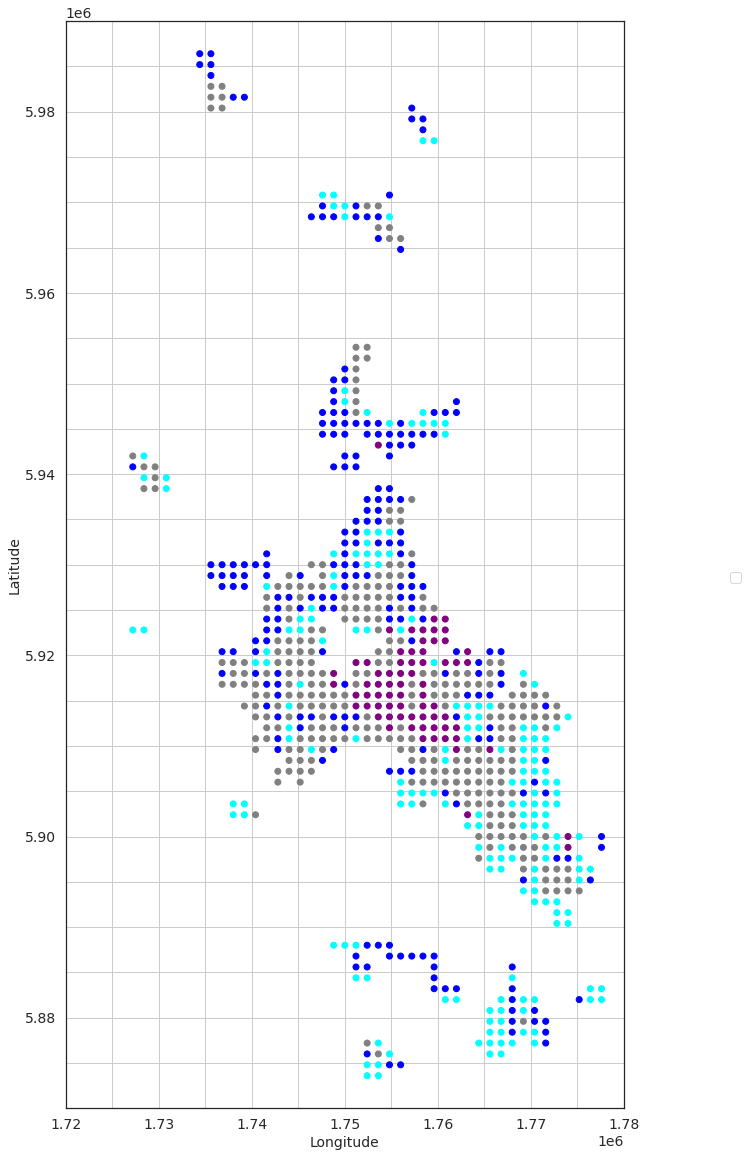

In [16]:
a=getCoordinatesMatDistribution(predoMaterials.copy())

In [56]:
a.groupby(["MATERIAL"]).agg({'Color':'count'})

,Color
MATERIAL,
AC,289
Iron,69
PE,220
PVC,184


Total Length of pipes with coordinates (GIS) 9172.63  in  198694 records
MaxLat: 1778247.88967 MinLat: 1727590.4969
MaxLong: 5986639.7981 MinLong: 5874217.251150001
0.0724775119389794   20.564415618534433
0.014771554470698542   12.028893780251416
0.0207561470941462   16.61024684201111
0.015187063922719748   13.820684438894979


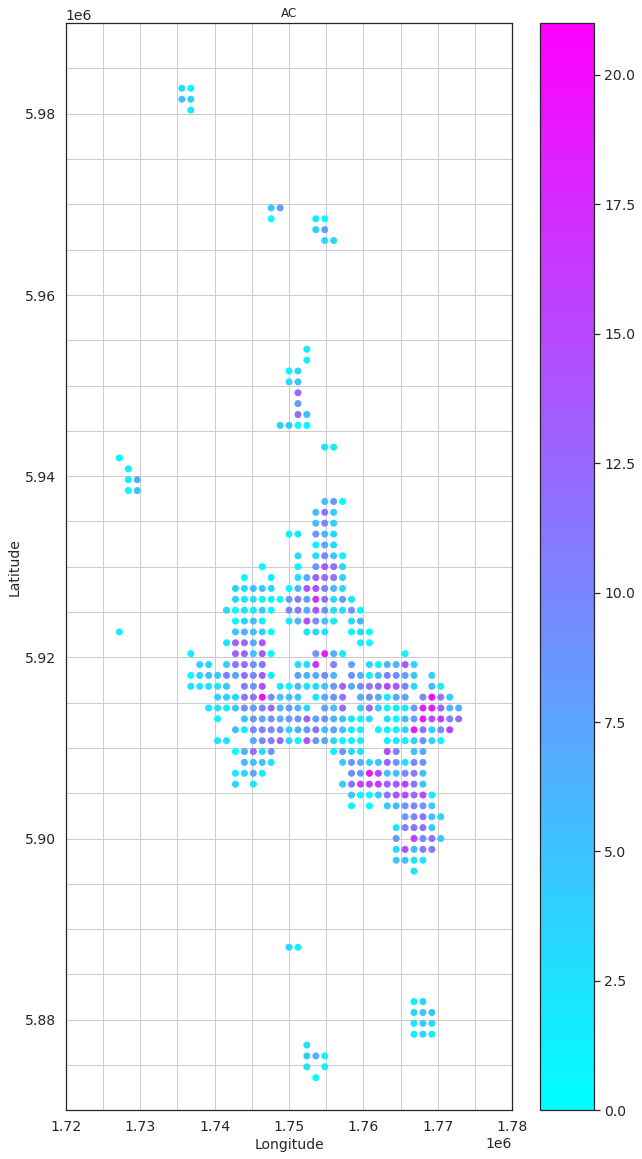

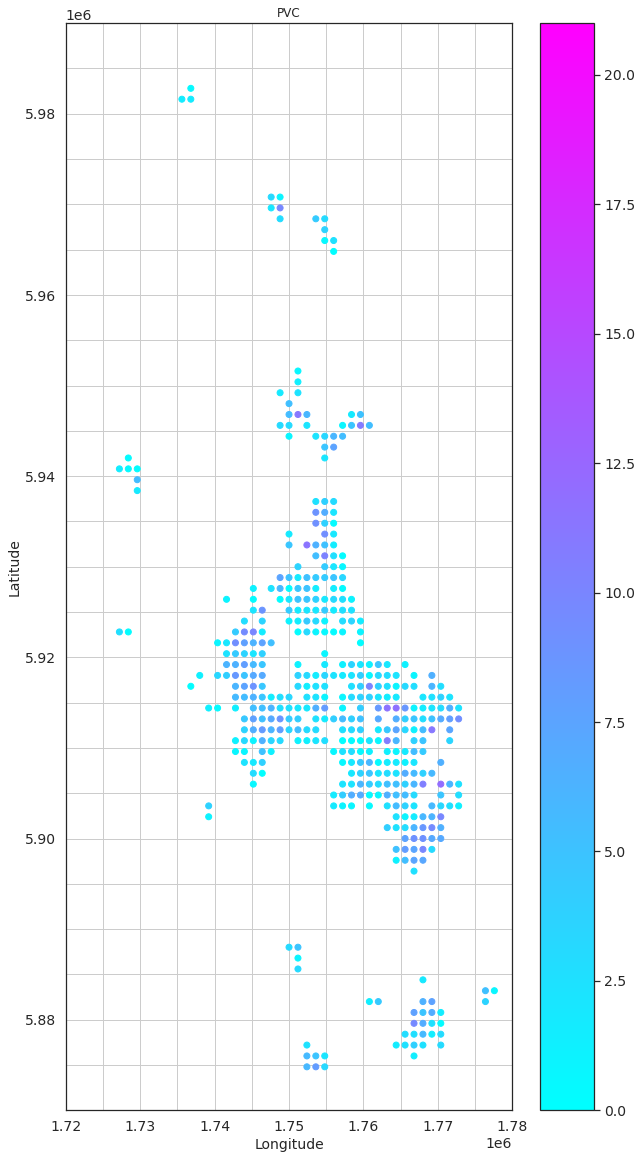

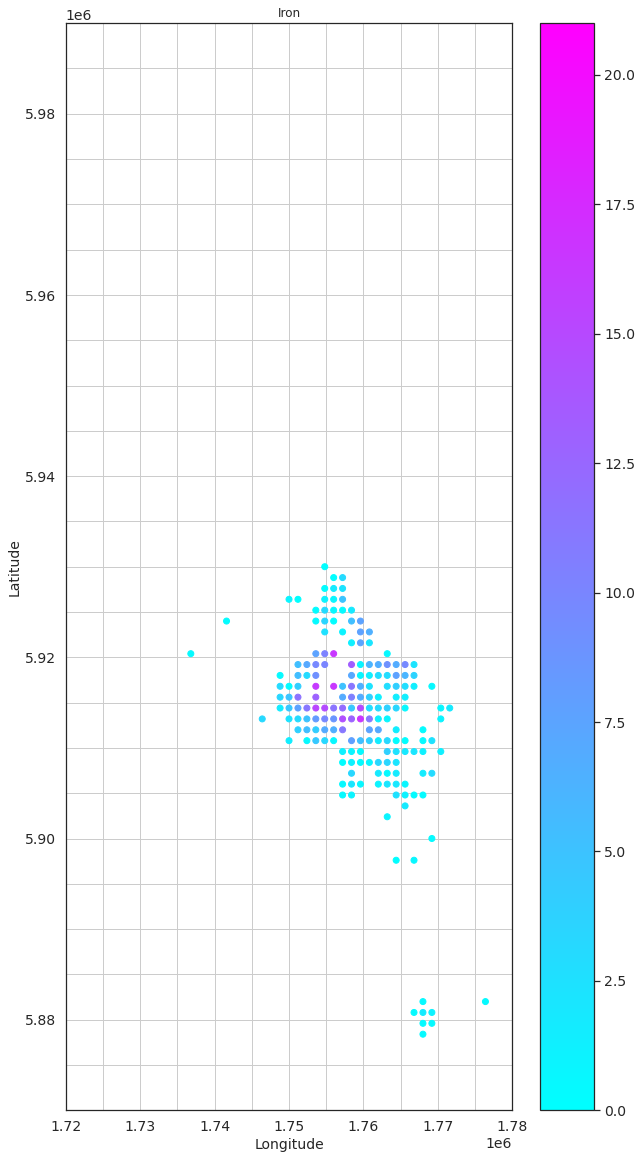

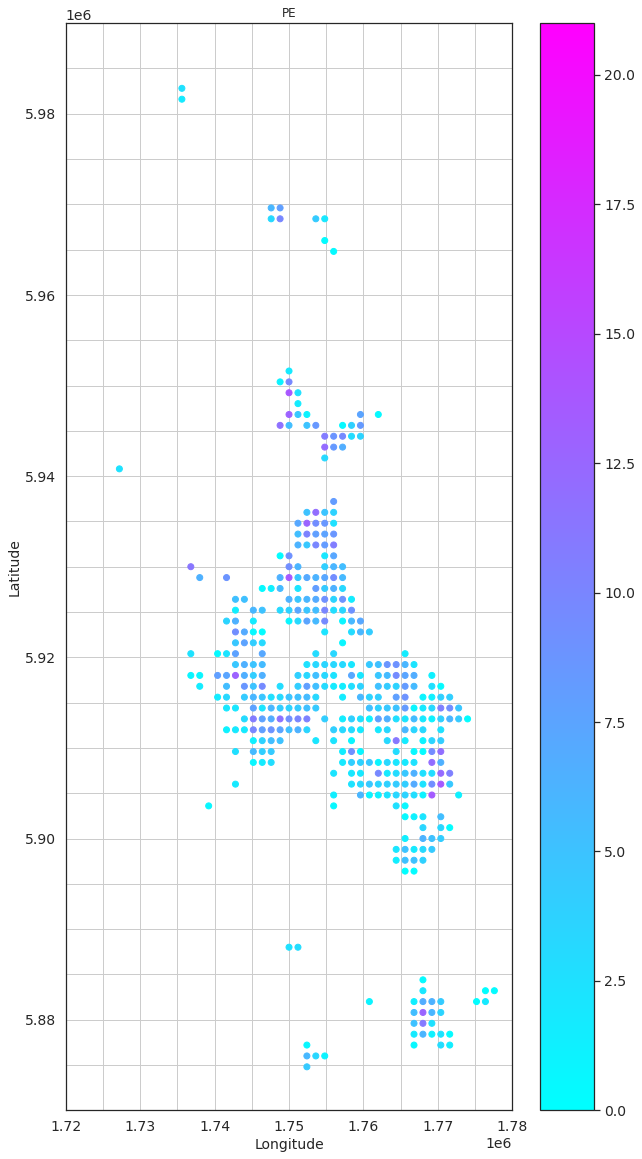

In [18]:
getCoordinatesHeatMapRange(predoMaterials.copy())  

# End Coordinates analysis ----------------------------------------------------

In [11]:
def getCorrelationMatrixDiameter(mDf):
    
    variables= mDf[[NOM_DIA_MM,'Age Today']].copy()
    weights= mDf[['Shape_Leng']].copy()

    des= smS.DescrStatsW(variables, weights=weights)
        
    print("Diameter and age correlation",des.corrcoef[0][1])

def getCorrelationMatrixPressure(mDf):
    
    variables= mDf[[NOM_DIA_MM,'Age Today','MOD_MAXPRE']].copy()
    weights= mDf[['Shape_Leng']].copy()

    des= smS.DescrStatsW(variables, weights=weights)
        
    print("Diameter and age correlation",des.corrcoef[0][1])
    print("Diameter and pressure correlation",des.corrcoef[0][2])
    print("Age and pressure correlation",des.corrcoef[1][2])

    
def getCorrelationMatrix(mDf):
    
    variables= mDf[[NOM_DIA_MM,'Age Today','MOD_MAXPRE',"Press_fluc"]].copy()
    weights= mDf[['Shape_Leng']].copy()

    des= smS.DescrStatsW(variables, weights=weights)
        
    print("Diameter and age correlation",des.corrcoef[0][1])
    print("Diameter and pressure correlation",des.corrcoef[0][2])
    print("Age and pressure correlation",des.corrcoef[1][2])
    print("Diameter and pressure fluc correlation",des.corrcoef[0][3])
    print("Age and pressure fluc correlation",des.corrcoef[1][3])
    print("Max p and pressure fluc correlation",des.corrcoef[2][3])

In [19]:
def getPoissonCorrelation(df, fluctuation=False):
    
    #adds pressure
    df=getFailuresWithPressures(df)
    
    if fluctuation:
        df= df[(df["MOD_MAXPRE"]>=20) & (df["MOD_MINPRE"]>=20) & (df["MOD_MAXPRE"]<120) & (df["MOD_MINPRE"]<120)].copy()
    
    variables=["NOM_DIA_MM","Age Today","MOD_MAXPRE","Press_fluc"]
    variablesR=["Diameter (mm)","Current age range (year)","Maximum Pressure (m)","Pressure Fluctuation (m)"]
    bins=[Diam_bins,Age_Range,PressMax_bins,PressFluc_bins]
    labels=[DRange_labels,AgeR_labels,PMaxRange_labels,PFlucRange_labels]
    
    regres=[]
    
    varo=2 #change here
    vari=3 #change here
    
    #remove invalid values
    for vr,v,bs,ls, in zip(variablesR[varo:vari],
                           variables[varo:vari],
                           bins[varo:vari],
                           labels[varo:vari]):
        
        df=putInRanges(df,vr,v,bs,ls,None,None,None)
    
    print("Variable",variablesR[varo:vari])
    
    df['Failures/Km/year']= df['Num of failures']/df['Shape_Leng']/6 
    
    for m in MATERIALS_PREDOMI:
        
        mDf= df[df[MATERIAL]==m].copy()
        
        print('MATERIAL: ',m)
        getCorrelationMatrix(mDf.copy())
        #getCorrelationMatrixDiameter(mDf.copy())
        #getCorrelationMatrixPressure(mDf.copy())
        
        dfAll= mDf.copy()
        print(dfAll.shape[0])
        
        X= dfAll[variables[varo:vari]]
        y= dfAll['Failures/Km/year'].copy()
        w= dfAll['Shape_Leng'].copy()
          
        X = sm.add_constant(X)
        
        model = sm.WLS(y, X,weights=w).fit() 
        
        for v in variables[varo:vari]:
            #material, diameter, slope, intercept, std dev, p-value of the slope, rsquared
            regres.append([m,v,model.params[v], model.params['const'], 
                       model.bse[v], model.pvalues[v], model.rsquared])
       
        #model = sm.GLM(y, X,family=sm.families.Poisson(),req_weights=w).fit() 
        #print(model.summary())
    
    df=pd.DataFrame(regres, columns =[MATERIAL,'Variable', 'Slope', 'Intercept', 
                                      'Std dev', 'Slope P-value', 'Rsquared'])
    
    df.to_csv('Output/Regressions/'+"VariablesVsFailR4"+'.csv') 
        
#getPoissonCorrelation(predoMaterials)

#predoMaterialsd=predoMaterials[predoMaterials['Age Today']>65].copy()
getPoissonCorrelation(predoMaterials,True)

Total Length of pipes with pressure (GIS) 9172.63  in  198694 records
Total Length of pipes with VALID distance to pressure (GIS) 6864.60  in  137710 records
(Main in service) Pipe length with valid  MOD_MAXPRE  6768.77  from original  6768.77
Variable ['Maximum Pressure (m)']
MATERIAL:  AC
Diameter and age correlation -0.10236352410962389
Diameter and pressure correlation -0.0037417826444692674
Age and pressure correlation -0.055197240250970184
Diameter and pressure fluc correlation -0.058450234602277266
Age and pressure fluc correlation 0.07042553029818181
Max p and pressure fluc correlation 0.4894620550139216
44353
MATERIAL:  PVC
Diameter and age correlation -0.3593559717289562
Diameter and pressure correlation 0.08691237707718598
Age and pressure correlation -0.11830264250167379
Diameter and pressure fluc correlation -0.05212674725018436
Age and pressure fluc correlation 0.05986742334481558
Max p and pressure fluc correlation 0.40485288011945636
28879
MATERIAL:  Iron
Diameter and a